## Configuration for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libpython2-stdlib python-opengl python2 python2-minimal
0 upgraded, 5 newly installed, 0 to remove and 23 not upgraded.
Need to get 621 kB of archives.
After this operation, 6,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-stdlib amd64 2.7.17-2ubuntu4 [7,072 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2 amd64 2.7.17-2ubuntu4 [26.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu f

# 03. DDPG

[T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2015.](https://arxiv.org/pdf/1509.02971.pdf)

Deep Q Network(DQN)([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) algorithm is combined advances in deep learning with reinforcement learning. However, while DQN solves problems with high-dimentional observation spaces, it can only handle discrete and low-dimentional action spaces because of using greedy policy. For learning in high-dimentional and continous action spaces, the authors combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). 

### Deterministic policy gradient
The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$ which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$

### Replay buffer
One challenge when using neural networks for reinforcement learning is that most optimization algorithms assume that **the samples are independently and identically distributed**. When the samples are generated from exploring sequentially in an environment this assumption no longer holds. The authors used a **replay buffer** to address these issues. Transitions were sampled from the environment according to the exploration policy and the tuple $(s_t, a_t, r_t, s_{t+1})$ was stored in the replay buffer. At each timestep the actor and critic are updated by sampling a minibatch uniformly from the buffer. It allows to benefit from learning across a set of **uncorrelated** transitions.

### Soft update target network
Since the network $(Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. Target netwokrs is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively, that are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

It greatly improves the stability of learning.

### Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

## Import modules

In [2]:
import copy
import random
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output

## Set random seed

In [3]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [4]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## OU Noise
**Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference: 
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

## Network
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, **ReLU** for hidden layers and **tanh** for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers **ReLU**. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are **uniformly distributed.**

In [6]:
class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()
        
        return action
    
    
class Critic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

## DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [7]:
class DDPGAgent:
    """DDPGAgent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
                
        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition to store in memory
        self.transition = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()
        
        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        
        self.transition = [state, selected_action]
        
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines
        
        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        
        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
                
        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # target update
        self._target_soft_update()
        
        return actor_loss.data, critic_loss.data
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:         
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size 
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
            
            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step, 
                    scores, 
                    actor_losses, 
                    critic_losses,
                )
                
        self.env.close()
        
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [8]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [9]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id)
env = ActionNormalizer(env)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Set random seed

In [10]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[777]

## Initialize

In [11]:
# parameters
num_frames = 50000
memory_size = 100000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

agent = DDPGAgent(
    env, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps
)

cpu


## Train

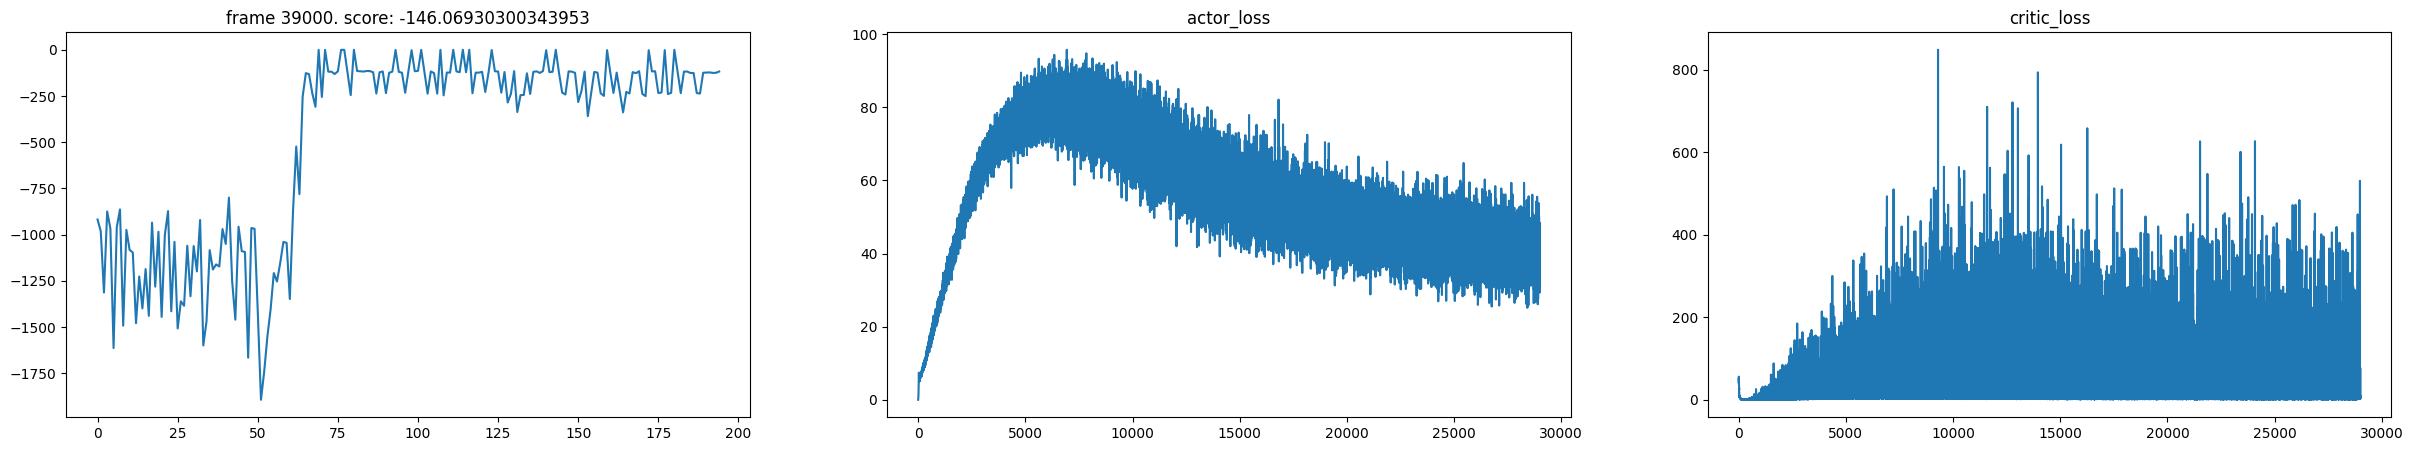

In [ ]:
agent.train(num_frames)

## Test
Run the trained agent (1 episode).

In [ ]:
# test
if IN_COLAB:
    agent.env = gym.wrappers.Monitor(agent.env, "videos", force=True)
frames = agent.test()

## Render

In [ ]:
if IN_COLAB:  # for colab
    import base64
    import glob
    import io
    import os

    from IPython.display import HTML, display

    def ipython_show_video(path: str) -> None:
        """Show a video at `path` within IPython Notebook."""
        if not os.path.isfile(path):
            raise NameError("Cannot access: {}".format(path))

        video = io.open(path, "r+b").read()
        encoded = base64.b64encode(video)

        display(HTML(
            data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
            </video>
            """.format(encoded.decode("ascii"))
        ))

    list_of_files = glob.glob("videos/*.mp4")
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    ipython_show_video(latest_file)

else:  # for jupyter
    from matplotlib import animation
    from JSAnimation.IPython_display import display_animation
    from IPython.display import display


    def display_frames_as_gif(frames):
        """Displays a list of frames as a gif, with controls."""
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames = len(frames), interval=50
        )
        display(display_animation(anim, default_mode='loop'))


    # display 
    display_frames_as_gif(frames)